In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("src") # go to parent dir
from detect import *
from reproject import *
import rosbag
from sklearn.metrics import mean_squared_error
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

rospy.init_node("sd_jupyter")


[[1.37544824e+03 0.00000000e+00 9.50562012e+02]
 [0.00000000e+00 1.37584045e+03 5.66901917e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [4]:
bag = rosbag.Bag("/home/xuhao/bags/dl_data/swarm_dl_one_ground_2019-08-18-05-52-01.bag")
poses, camera, depths = read_bag(bag)
dp2 = parse_ros_pose_ts(poses[2])
dp4 = parse_ros_pose_ts(poses[4])

In [5]:
sd = SwarmDetector(debug_show="cv",conf_thres=0.6)

In [6]:
### index = 100
step = 1
err = []
est_3d_poses = []
gt_3d_poses = []

for index in range(10,len(camera), step):
    t_cam_on_drone = np.array([0.044, -0.035, 0.0])
    R_cam_on_drone = np.array([[0, 0, 1],
             [-1, 0, 0],
             [0, -1, 0]])

    img_msg = camera[index]
    dposyolo_camframe  = sd.img_callback(img_msg, depths[index])
    if dposyolo_camframe is None:
        continue
    dposyolo_camframe =  dposyolo_camframe
    pos4 = dp4["pos_func"](img_msg.header.stamp.to_sec()) + np.array([0.053, -0.05, -0.075])
    quat4 = dp4["quat_func"](img_msg.header.stamp.to_sec())
    quat2 = dp2["quat_func"](img_msg.header.stamp.to_sec())
    pos2 = dp2["pos_func"](img_msg.header.stamp.to_sec()) + t_cam_on_drone
    dpos_gt = pos4 - pos2 

    r2 = quaternion_matrix(quat2)[0:3,0:3]
    r2cam = np.dot(r2, R_cam_on_drone)
    dposyolo_global = np.dot(r2cam, dposyolo_camframe)
    dyolo_gt = dposyolo_global - dpos_gt
    if math.fabs(dyolo_gt[0]) > 0.5 or math.fabs(dyolo_gt[1]) > 0.5 or math.fabs(dyolo_gt[2] > 0.5):
        continue
    err.append(dposyolo_global - dpos_gt)
    est_3d_poses.append(dposyolo_global + pos2)

err = numpy.array(err)

[INFO] [1566187955.683585, 0.000000]: Detection use time 0.000000ms
[INFO] [1566187955.685329, 0.000000]: Total use time 0.000000ms


IndexError: list index out of range

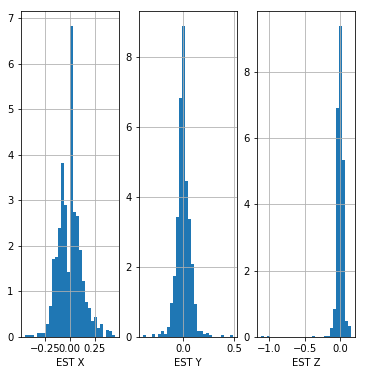

XYZ MEAN 1.7 0.9 -0.9 cm RMSE 11.7 6.8 6.8cm


Text(0.5,0,'Z')

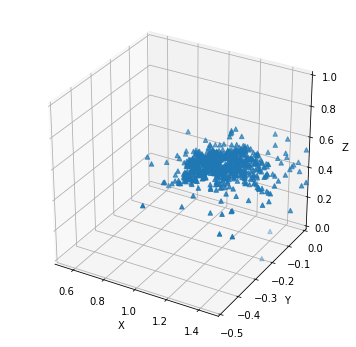

In [75]:
err = np.array(err)
est_3d_poses = np.array(est_3d_poses )
plt.figure(100, figsize=(6, 6))
plt.subplot(131)
plt.hist(est_3d_poses[:,0] - np.mean(est_3d_poses[:,0]), density=True, bins=30)
plt.xlabel("EST X")
plt.grid()

plt.subplot(132)
plt.hist(est_3d_poses[:,1] - np.mean(est_3d_poses[:,1]), density=True, bins=30)
plt.xlabel("EST Y")
plt.grid()

plt.subplot(133)
plt.hist(est_3d_poses[:,2] - np.mean(est_3d_poses[:,2]), density=True, bins=30)
plt.xlabel("EST Z")
plt.grid()
plt.show()


print("XYZ MEAN {:3.1f} {:3.1f} {:3.1f} cm RMSE {:3.1f} {:3.1f} {:3.1f}cm".format(
    np.mean(err[:,0])*100, 
    np.mean(err[:,1])*100, 
    np.mean(err[:,2])*100,
    np.sqrt(np.mean((err[:,0])**2))*100,
    np.sqrt(np.mean((err[:,1])**2))*100,
    np.sqrt(np.mean((err[:,2])**2))*100))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(est_3d_poses[:,0], est_3d_poses[:,1], est_3d_poses[:,2], marker="^")
#[ 1.16626224, -0.21409655,  0.52796817]
ax.set_xlim3d(0.5, 1.5)
ax.set_ylim3d(-0.5, 0.)
ax.set_zlim3d(0, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


In [54]:
np.mean(est_3d_poses, axis=0)

array([ 1.18326783, -0.21490628,  0.54642326])

In [37]:
math.sqrt(np.mean((err[:,0])**2))

0.3694984835093118